# NaiveBayes

Let us train NaiveBayes model using standard implementation 
and compare it with our own computation. TO make our computation simpler
we will include only categorical variables in the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import naive_bayes
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

path = "heart.csv"
heart = pd.read_csv(path)

As practitioners we must always be wary of Overfitting and underfitting. 

We consider when the performance of a classifier falls by 50% from 
training to test dataset to be due to overfitting.

We consider when the performance of a classifier is below 50% to be
an indication of a weak classifier unable to learn. Also known as
underfitting.

Let us create some utility functions.

In [2]:
def is_overfitting(train_y, train_y_hat, test_y, test_y_hat):
    # if the accuracy from training is much more than accuracy testing phase
    # then we conclude Model is overfitting 
    # unable to generalize
    tracc = accuracy_score(train_y, train_y_hat)
    tstacc = accuracy_score(test_y, test_y_hat)
    if tracc > 2 * tstacc:
        return "model is overfitting -- too complex"
    else:
        return "There is no overfitting, model is an effective learner@ [" + str(round(tracc,2)) + "] training accuracy vs testing accuracy=[" + str(round(tstacc,2)) + "]"                                                                               
        

def is_underfitting(train_y, train_y_hat):
    # if the accuracy from training is much more than accuracy testing phase
    # then we conclude Model is overfitting 
    # unable to generalize
    tracc = accuracy_score(train_y, train_y_hat)
    if 0.5 >  tracc:
        return "model is deficient"
    else:
        return "There is no underfitting.  model is an effective learner@ [" + str(round(tracc,2)) + "] accuracy"

## Load data and EDA

Let us load the data.
And subset it to include only categorical predictors.

In [3]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
catheart = heart.iloc[:,[1,2,5,6,8,10,11,12,13]]

## Preliminary EDA

In [5]:
catheart.head()

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,1,3,1,0,0,0,0,1,1
1,1,2,0,1,0,0,0,2,1
2,0,1,0,0,0,2,0,2,1
3,1,1,0,1,0,2,0,2,1
4,0,0,0,1,1,2,0,2,1


In [6]:
catheart.shape

(303, 9)

In [7]:
catheart["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

## Repeatable and Reproducible Experiments
Set a seed for repeatable/reproducible random number sequence
and split the data into training/test sets.
<span style="color:red">**NOTE: The RMD file used set.seed and a selection process to choose the training/test split.  I will show how could be done in python but will ultimately use a list of the same observations so the model results are consistent.**</span>

In [8]:
# Here's how to split the data in python
X = catheart.loc[:, catheart.columns != "target"]
Y = catheart["target"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 43)

# Here's the rows selected by the process in R
r_tstidx = [44, 296, 196, 149, 66, 261, 216, 7, 167, 130, 270, 225, 180, 147, 173, 22, 78, 228, 259, 110, 161, 142, 297, 72, 301, 39, 249, 274, 81, 121, 286, 98, 55, 230, 263, 120, 102, 291, 49, 245, 128, 166, 40, 154, 89, 218, 43, 165, 85, 184, 158, 303, 150, 169, 170, 67, 99, 9, 21, 205, 123, 209, 300, 234, 281, 5, 69, 268, 74, 93, 236, 30, 254, 279, 45, 176, 90, 233, 237, 103, 38, 191, 220, 194, 285, 217, 80, 115, 88, 299, 127, 227, 293, 145, 248, 298, 104, 179, 117, 160, 61, 174, 70, 221, 182, 140, 256, 146, 253, 136, 290, 222, 24, 125, 143, 212, 292, 276, 239, 34, 244, 219, 157, 162, 294, 168, 151, 114, 52, 210, 11, 42, 97, 163, 266, 269, 264, 108, 208, 172, 175, 107, 64, 27, 201, 211, 8, 18, 116, 59, 273, 251, 159, 181, 229, 223, 10, 1, 153, 189, 129, 156, 25, 283, 284, 235, 101, 12, 33, 92, 91, 152, 71, 133, 141, 77, 131, 250, 135, 195, 207, 242, 54, 109, 185, 126, 198, 111, 271, 76, 86, 105, 203, 164, 206, 199, 275, 202, 272, 118, 31, 139, 200, 14, 257, 2, 37, 138, 19, 94, 302, 3]
python_tstidx = [x - 1 for x in r_tstidx]
trdidx = catheart.index.isin(python_tstidx)
trcatheart = catheart[trdidx]
tstcatheart = catheart[~trdidx]

## Check for class imbalance
Here we check visually to see if there are labels which occur in the single digit.
If a class exists in just once, if we wish to learn then we cannot test the algorithm for that class and if we include it in the test then we cannot train on it.
There are many statistical techniques to correct for class imbalance, left to another follow up workshop.

In [9]:
catheart["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

## Training and testing sets must be similar to the entire dataset
Are the training and test set distributed approximately similar to
given dataset. This is important so that statistics that applies 
to training and test sets, are applicable to the entire dataset.
### Otherwise, we cannot generalize.

In [10]:
trcatheart.shape

(212, 9)

In [11]:
trcatheart["target"].value_counts()

1    114
0     98
Name: target, dtype: int64

In [12]:
tstcatheart.shape

(91, 9)

In [13]:
tstcatheart["target"].value_counts()

1    51
0    40
Name: target, dtype: int64

Train NB model, standard implementation using training set

In [14]:
X_train = trcatheart.loc[:, trcatheart.columns != "target"]
Y_train = trcatheart["target"]
nbtr_model = naive_bayes.CategoricalNB().fit(X_train, Y_train)

Performance over the training set

In [15]:
nbtr_trclass = nbtr_model.predict(X_train)
pd.DataFrame(confusion_matrix(Y_train, nbtr_trclass))

,0,1
0,81,17
1,13,101


<span style="color:red">**NOTE: This model preforms slightly better than the R NaiveBayes model.  I currently cannot explain the difference.**</span>

In [16]:
print(classification_report(Y_train, nbtr_trclass, digits = 4))

              precision    recall  f1-score   support

           0     0.8617    0.8265    0.8438        98
           1     0.8559    0.8860    0.8707       114

    accuracy                         0.8585       212
   macro avg     0.8588    0.8562    0.8572       212
weighted avg     0.8586    0.8585    0.8582       212



Performance over held out data, the test set

In [17]:
X_test = tstcatheart.loc[:, tstcatheart.columns != "target"]
Y_test = tstcatheart["target"]
nbtr_tsclass = nbtr_model.predict(X_test)
pd.DataFrame(confusion_matrix(Y_test, nbtr_tsclass))

,0,1
0,30,10
1,3,48


In [18]:
print(classification_report(Y_test, nbtr_tsclass, digits = 4))

              precision    recall  f1-score   support

           0     0.9091    0.7500    0.8219        40
           1     0.8276    0.9412    0.8807        51

    accuracy                         0.8571        91
   macro avg     0.8683    0.8456    0.8513        91
weighted avg     0.8634    0.8571    0.8549        91



## Underfitting / Overfitting

In [19]:
print(is_underfitting(Y_train, nbtr_trclass))

There is no underfitting.  model is an effective learner@ [0.86] accuracy


In [20]:
print(is_overfitting(Y_train, nbtr_trclass, Y_test, nbtr_tsclass))

There is no overfitting, model is an effective learner@ [0.86] training accuracy vs testing accuracy=[0.86]


## Conditionally Independent Class Probabilities

Let us now compute NaiveBayes probabilities for each class
directly from data.
Given any predictor and a value
we compute the class conditional probabilities

p(c1|x) and p(c2|x) using 

p(c1|X)=p(x1|c1)p(x2|c1)p(x3|c1)..p(xn|c1)p(c1)

and

p(c2|X)=p(x1|c2)p(x2|c2)p(x3|c2)..p(xn|c2)p(c2)

Here p(c1)=frequency of c1 / total frequency

p(x1|c1)=frequency of x1 given c1/frequency of c1

we assign the class with the higher probability

In [21]:
trcathearttarget_0 = trcatheart.loc[trcatheart["target"] == 0]
trcathearttarget_1 = trcatheart.loc[trcatheart["target"] == 1]
tstcathearttarget_0 = tstcatheart.loc[tstcatheart["target"] == 0]
tstcathearttarget_1 = tstcatheart.loc[tstcatheart["target"] == 1]

We compute class frequencies as follows, 
the number of rows in each class is the frequency of that class.
## class c1 proportion

In [22]:
c0freq = len(trcathearttarget_0)
c1freq = len(trcathearttarget_1)
p0 = c0freq / (c0freq + c1freq)
p1 = c1freq / (c0freq + c1freq)
print((p0,p1))

(0.46226415094339623, 0.5377358490566038)


We count, the number of observations in which the attribute has the given value
## We return the two proportions for a binary classifier.

In [23]:
def classProbabilities(dsetc1,dsetc2,prop,val,c1prob,c2prob):
    propdsetc1 = dsetc1.loc[dsetc1[prop]==val]
    propdsetc2 = dsetc2.loc[dsetc2[prop]==val]
    return (len(propdsetc1) / len(dsetc1), len(propdsetc2) / len(dsetc1))

Let us put our utility functions to test, calculate conditional probability

In [24]:
trcatheart.loc[295,]

sex        1
cp         0
fbs        0
restecg    0
exang      1
slope      2
ca         2
thal       3
target     0
Name: 295, dtype: int64

In [25]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'sex',1,p0,p1)

(0.8061224489795918, 0.673469387755102)

In [26]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'cp',0,p0,p1)

(0.7653061224489796, 0.29591836734693877)

In [27]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'fbs',0,p0,p1)

(0.8571428571428571, 1.010204081632653)

In [28]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'restecg',0,p0,p1)

(0.5816326530612245, 0.46938775510204084)

In [29]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'exang',1,p0,p1)

(0.5510204081632653, 0.20408163265306123)

In [30]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'slope',2,p0,p1)

(0.22448979591836735, 0.6938775510204082)

In [31]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'ca',2,p0,p1)

(0.25510204081632654, 0.04081632653061224)

In [32]:
classProbabilities(trcathearttarget_0,trcathearttarget_1,'thal',3,p0,p1)

(0.673469387755102, 0.20408163265306123)

In [33]:
xx = [
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'sex',1,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'cp',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'fbs',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'restecg',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'exang',1,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'slope',2,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'ca',2,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'thal',3,p0,p1),
  (p0,p1)]
(p0,p1)

(0.46226415094339623, 0.5377358490566038)

In [34]:
mx = np.array(xx)
cp = np.prod(mx, axis=0)
pred_class = [i for (i, v) in zip([0,1], cp == max(cp)) if v][0]
actual_class = trcatheart.loc[295,]["target"]
actual_class

0

In [35]:
def binominal_classification_result(actual_class, pred_class):
    if actual_class == 0:
        if pred_class == 0:
            print("TP")
        else:
            print("FN")
    elif pred_class == 1:
        print("TN")
    else:
        print("FP")

binominal_classification_result(actual_class, pred_class)

TP


In [36]:
tstcatheart.loc[19,]

sex        0
cp         3
fbs        0
restecg    1
exang      0
slope      2
ca         2
thal       2
target     1
Name: 19, dtype: int64

In [37]:
xx = [
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'sex',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'cp',1,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'fbs',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'restecg',1,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'exang',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'slope',2,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'ca',2,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'thal',2,p0,p1),
  (p0,p1)]
mx = np.array(xx)
cp = np.prod(mx, axis=0)
pred_class = [i for (i, v) in zip([0,1], cp == max(cp)) if v][0]
pred_class

1

In [38]:
actual_class = tstcatheart.loc[19,]["target"]
actual_class

1

In [39]:
binominal_classification_result(actual_class, pred_class)

TN


## NOTE THAT we are using the distribution of training set to evaluate the test set probabilities otherwise we could not claim to be generalizing
Let us do one more 23rd observation from the test set.seed

<span style="color:red">**NOTE: This is the 57th row in R.**</span>

In [40]:
tstcatheart.loc[56,]

sex        1
cp         0
fbs        0
restecg    0
exang      0
slope      2
ca         0
thal       2
target     1
Name: 56, dtype: int64

In [41]:
xx = [
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'sex',1,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'cp',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'fbs',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'restecg',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'exang',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'slope',2,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'ca',0,p0,p1),
  classProbabilities(trcathearttarget_0,trcathearttarget_1,'thal',2,p0,p1),
  (p0,p1)]
mx = np.array(xx)
cp = np.prod(mx, axis=0)
pred_class = [i for (i, v) in zip([0,1], cp == max(cp)) if v][0]
pred_class

1

In [42]:
actual_class = tstcatheart.loc[56,]["target"]
actual_class

1

In [43]:
binominal_classification_result(actual_class, pred_class)

TN


In [44]:
def evaluate_naiveBayes(df,targetclass,trdsetcl1,trdsetcl2,cl1prob,cl2prob,print_counts=False):
    nv = [n for n in df.columns if n not in [targetclass]]
    xx = []
    for col in nv:
        vv = df[col]
        xx.append(vv.apply(lambda x: classProbabilities(trdsetcl1,trdsetcl2,col,x,p0,p1)).to_list())
    mx = np.array(xx)
    cp = np.prod(mx, axis=0)
    temp = pd.DataFrame(cp, index = df.index)
    temp["max"] = temp.apply(np.max, axis=1)
    temp["GT"] = df[targetclass]
    temp["Pred"] = np.where((temp["max"] == temp[0]), 0, 1)
    temp["metric"] = np.where((temp["Pred"] == 1), np.where(temp["GT"] == 1, "TP", "FP",), np.where(temp["GT"] == 0, "TN", "FN"))
    if print_counts:
        print(Counter(temp["metric"]))
    return(pd.DataFrame(confusion_matrix(temp["GT"], temp["Pred"])))

evaluate_naiveBayes(tstcatheart, "target", trcathearttarget_0, trcathearttarget_1, p0, p1, True)

Counter({'TP': 49, 'TN': 26, 'FP': 14, 'FN': 2})


,0,1
0,26,14
1,2,49


<span style="color:red">**NOTE: There is one more TN and one less FP than in the R implementation that is currently unexplained.**</span>

## Final observation 

Note that we estimated the class probabilities using the training set
however, we compute the metric using the test set.

## Is that not what we want?

Statistics and probabilities is one big hat from which we can pull many rabbits,
and if you are NOT cautious you can end up with a 3 legged rabbit.
This classifier assumes that features are uncorrelated and yet we achieved significant
inferences.

If you recall, the scikitlearn CategoricalNB achieved 

In [45]:
pd.DataFrame(confusion_matrix(Y_test, nbtr_tsclass))

,0,1
0,30,10
1,3,48


in comparison to our naive implementation.

In [46]:
evaluate_naiveBayes(tstcatheart, "target", trcathearttarget_0, trcathearttarget_1, p0, p1)

,0,1
0,26,14
1,2,49


Let us plot the ROCR curve and determine AUC for the scikitlearn CategoricalNB standard
implementation.

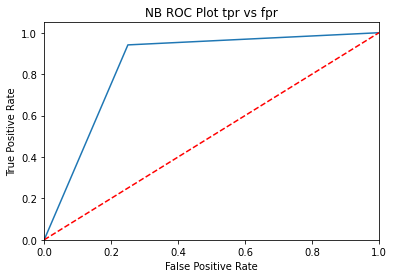

In [47]:
fpr, tpr, thresholds = roc_curve(Y_test, nbtr_tsclass)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NB ROC Plot tpr vs fpr')
plt.show()

In [48]:
print("NB AUC = " + str(roc_auc_score(Y_test, nbtr_tsclass)))

NB AUC = 0.8455882352941176
